# Introduction

Our input is the resulting dataset from the Exploratory Data Analysis and the Feature Engineering performed on any original datasets. <br/>

## Imports

In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

In [3]:
# File system manangement
import os

In [4]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# prepare data
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
# models and metrics
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
# from sklearn.metrics import roc_auc_score (auc(fpr, tpr) from roc_curve)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [88]:
# LightGBMError: Do not support special JSON characters in feature name
import re

In [140]:
# hyperopt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval

In [163]:
# persistant search for hyperopt
import threading as th
import keyboard

In [141]:
# pickle
import pickle

In [6]:
# clean - garbage collection
import gc
gc.enable()

In [7]:
# custom functions
from ipynb.fs.full.functions import heatmap, missing_values_table, convert_types, split_show_results, show_results

In [8]:
''' warning show results to debug in functions (plot_roc_curve issue)'''

' warning show results to debug in functions (plot_roc_curve issue)'

In [8]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
# paramètres
# to display any columns
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
sns.set(style="ticks")
sns.set_style('whitegrid')

## Read in Data

In [10]:
# List files available
print(os.listdir('Data/'))

['aggregated.csv', 'application_test.csv', 'application_train.csv', 'application_trunc.csv', 'backup_aggregated.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'Descriptions.xlsx', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [12]:
# get back result of EDA, FE, & first level FS
any_application = pd.read_csv('Data/application_trunc.csv')

In [13]:
any_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Columns: 255 entries, index to EMERGENCYSTATE_MODE_Yes
dtypes: float64(73), int64(182)
memory usage: 693.1 MB


In [14]:
print(any_application.shape)
any_application.head(1)

(356251, 255)


,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_BIRTH,N_DAYS_EMPLOYED_RATIO,N_INCOME_CREDIT_RATIO,N_INCOME_PER_PERSON,N_ANNUITY_INCOME_RATIO,N_CREDIT_TERM,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Businessman,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Commercial associate,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Maternity leave,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_State servant,OCCUPATION_TYPE_Student,OCCUPATION_TYPE_Unemployed,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_Working,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUN

! we've lot a few rows ! there is an 'index' column, useless

In [15]:
# remove index column
any_application.drop(columns=['index'], inplace=True)

# Data preparation

### Get back train - test from "Any applications"

In [16]:
# keep training applications only
train = any_application[any_application['TARGET'].notna()]
test = any_application[any_application['TARGET'].isna()]

In [17]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ', test.shape)

Training set full shape:  (307507, 254)
Testing set full shape:  (48744, 254)


In [18]:
train.head(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_BIRTH,N_DAYS_EMPLOYED_RATIO,N_INCOME_CREDIT_RATIO,N_INCOME_PER_PERSON,N_ANNUITY_INCOME_RATIO,N_CREDIT_TERM,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Businessman,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Commercial associate,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Maternity leave,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_State servant,OCCUPATION_TYPE_Student,OCCUPATION_TYPE_Unemployed,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_Working,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WE

In [19]:
# set index with SK_ID_CURR
train = train.set_index('SK_ID_CURR')
test = test.set_index('SK_ID_CURR')

### Data integrity

Missing values affect classifier performance and ability to remedy class imbalance (i.e. ability to build consistent synthetic data in case of SMOTE use to upsample minority class), we have to track the features with many missing value, decide if we should keep them and find the best imputation strategy.

In [20]:
# check for missing values
missing_values = missing_values_table(train)

Your selected dataframe has 253 columns.
There are 66 columns that have missing values.


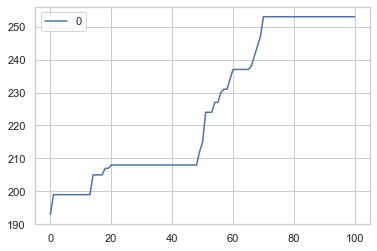

4:80: E501 line too long (103 > 79 characters)


In [21]:
# get the missing curve
missing_list = []
for i in np.arange(0, 101, 1):
    missing = train.shape[1] - len(list(missing_values.index[missing_values['% of Total Values'] > i]))
    missing_list.append(missing)
pd.DataFrame(missing_list).plot()

In [73]:
len(list(missing_values.index[missing_values['% of Total Values'] > 90]))

0

## Train, Test split

SK_ID_CURR is now he index and we build a separated target y_ df from the training data X_. <br/>
Note that we have to build it in a DataFrame format (in order to extract a sample after the train-test split.

In [29]:
def my_split(data=train,
             split_size=0.2,
             impute_strategy='median',
             scale_strategy=False):
    '''function that split data into train and test according to split_size (test)
    and impute missing values according to the impute strategy
    and MinMaxScale features'''
    # drop the target from the training data
    if 'TARGET' in data:
        X_ = data.drop(columns=['TARGET'])
    else:
        X_ = data.copy()
    y_ = data['TARGET']
    # to keep df format : store columns & index
    columns = X_.columns
    index = X_.index
    # imputation of missing values
    imputer = SimpleImputer(
        missing_values=np.nan,
        strategy=impute_strategy)
    imputer.fit(X_)
    X_ = pd.DataFrame(
        imputer.fit_transform(X_),
        columns=columns,
        index=index)
    # Scale if True, each feature to 0-1
    if scale_strategy is True:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(X_)
        X_ = pd.DataFrame(
            scaler.fit_transform(X_),
            columns=columns,
            index=index)
    # Split data into train and test set (stratify by target)
    X_train, X_test, y_train, y_test = train_test_split(
        X_,
        y_,
        stratify=y_,
        test_size=split_size,
        random_state=42)
    print('Training data shape: ', X_train.shape)
    print('Testing data shape: ', X_test.shape)
    print('Labels train data shape: ', y_train.shape)
    print('Labels test data shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test, columns

In [30]:
X_train, X_test, y_train, y_test, features = my_split()

Training data shape:  (246005, 252)
Testing data shape:  (61502, 252)
Labels train data shape:  (246005,)
Labels test data shape:  (61502,)


### Sampling - class balance

Cf. below, SMOTE test versus class_weight='balanced'.

Introduce and test a downsampling method?

### Sampling - model selection process

! we need to work with proper df types

In [195]:
# randomly sample the data an apply to target
X_train_sample = X_train.sample(n=1000, random_state=42)
# Get the indexes to sample target_vector
sample_index = X_train_sample.index
mask = (y_train.index.isin(sample_index))
y_train_sample = y_train[mask]
# print results
len(y_train_sample)

1000

In [197]:
X_train_re_sample = X_train_sample.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [47]:
# control failure rate of sample
print('global failure rate: ',
     round(100 * y_train_sample.value_counts()[1] / (y_train_sample.value_counts()[1] + y_train_sample.value_counts()[0]), 2))

global failure rate:  7.4


3:6: E128 continuation line under-indented for visual indent


# Model evaluation

## Metric: Area Under Roc & "Damage Scoring"

First off all, accuracy (Σ True positive or negative / Σ Total) is __not a relevant metric__ in our case, mainly due to the __class imbalance__, with over than 90% accuracy if we predict the majority class only, granting loan to anyone and facing any risky clients failures.
The area under the ROC curve offers a more valuable metric, that can be trusted for models comparison. A model that simply guesses at random will have an ROC AUC of 0.5. Any improvement of AUC score, up to ideal 1, means the model gets to a minimal False positive rate and a maximal True positive rate.
In our case, we'll even discuss the opportunity of building our own score, based on an detailed interpretation of the confusion matrix (see [F-score](https://en.wikipedia.org/wiki/F-score)) to more accurately define what could be the "best" retuls, in terms of the financial opportunity or damages for the company. This lead to build a compromise between approval of risky clients and rejection og good ones. <br/>
After studying the resulting populated confusion matrix, we decided to use Fbeta to value the relative importance of recall over precision (with an illustrative value of beta=7), which is a good approach to value the financial damage of granting a loan to a failure-risky client than rejecting a loan to a "good" client.

## Classifiers evaluation techniques

1. first run and compare 

2. K-Fold cross validation technique

3. Hyperopt? We choose to work with the 5.2k stars lib [hyperopt](https://github.com/hyperopt/hyperopt) to find the most relevant model.

## Classifiers training

Let's create a model_run function that will instanciate any classifier and get results.

In [80]:
def model_run(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    cols=None
):

    model.fit(X_train[cols], y_train)
    y_pred = model.predict(X_test[cols])
    y_pred_proba = model.predict_proba(X_test[cols])[:, 1]

    f7 = fbeta_score(y_test, y_pred, beta=7)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)

    print(model)
    print('AUC score: ', round(auc_score, 4))
    print('Fbeta score (7): ', round(f7, 4))

    return fpr, tpr, auc_score, f7

### Naive Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5.

In [81]:
naive = GaussianNB()
fpr_naive, tpr_naive, auc_score_naive, f7_naive = model_run(
    naive,
    X_train,
    y_train,
    X_test,
    y_test,
    cols=X_train.columns
)

GaussianNB()
AUC score:  0.5967
Fbeta score (7):  0.0119


### Logistic Regression

In [93]:
logreg = LogisticRegression()
fpr_logreg, tpr_logreg, auc_score_logreg, f7_logreg = model_run(
    logreg,
    X_train,
    y_train,
    X_test,
    y_test,
    cols=X_train.columns
)

LogisticRegression()
AUC score:  0.6202
Fbeta score (7):  0.0


### Random Forest

In [83]:
rndfor = RandomForestClassifier()
fpr_rndfor, tpr_rndfor, auc_score_rndfor, f7_rndfor = model_run(
    rndfor,
    X_train,
    y_train,
    X_test,
    y_test,
    cols=X_train.columns
)

RandomForestClassifier()
AUC score:  0.7101
Fbeta score (7):  0.001


### LightGBM

In [90]:
# features format
X_train_re = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [92]:
liggbm = lgb.LGBMClassifier()
fpr_liggbm, tpr_liggbm, auc_score_liggbm, f7_liggbm = model_run(
    liggbm,
    X_train_re,
    y_train,
    X_test_re,
    y_test,
    cols=X_train_re.columns
)

LGBMClassifier()
AUC score:  0.7662
Fbeta score (7):  0.0189


### Collect results

In [94]:
# Collect results
classifier_names = [
    'Gaussian Naive Bayes',
    'Logistic Regression',
    'Random Forest',
    'LightGBM']
auc_scores = [
    auc_score_naive,
    auc_score_logreg,
    auc_score_rndfor,
    auc_score_liggbm]
f7_scores = [
    f7_naive,
    f7_logreg,
    f7_rndfor,
    f7_liggbm]

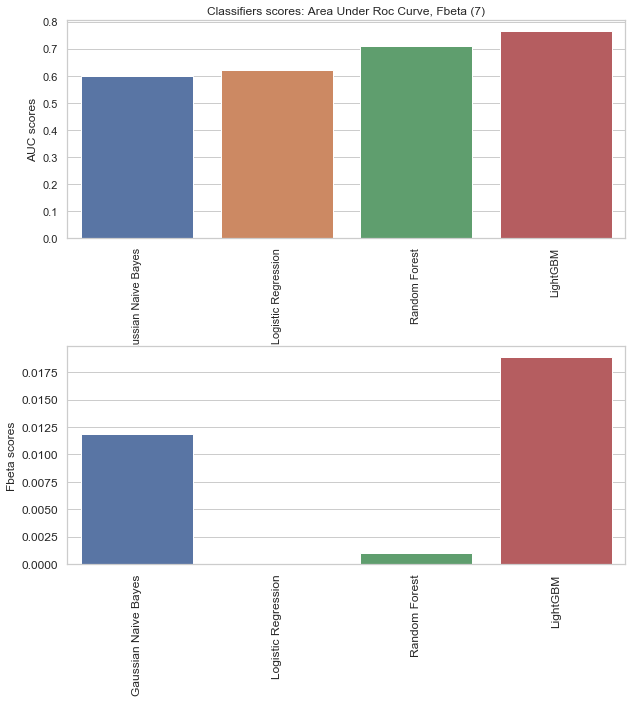

In [98]:
# display results
sns.set_color_codes("colorblind")
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title('Classifiers scores: Area Under Roc Curve, Fbeta (7)')
s1 = sns.barplot(x=classifier_names, y=auc_scores)
s1.set_xticklabels(s1.get_xticklabels(), rotation=90)
plt.ylabel('AUC scores', fontsize=12)
plt.subplot(212)
s2 = sns.barplot(x=classifier_names, y=f7_scores)
s2.set_xticklabels(s2.get_xticklabels(), rotation=90)
plt.ylabel('Fbeta scores', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.subplots_adjust(hspace=0.5)
plt.show()

Text(0, 0.5, 'True Positive Rate')

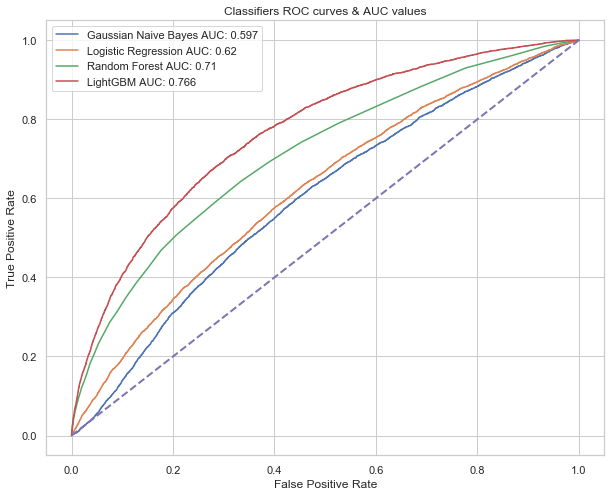

In [109]:
# display roc curves
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(
    fpr_naive,
    tpr_naive,
    label=str(classifier_names[0])
    + ' AUC: '
    + str(round(auc_score_naive, 3)))
ax.plot(
    fpr_logreg,
    tpr_logreg,
    label=str(classifier_names[1])
    + ' AUC: '
    + str(round(auc_score_logreg, 3)))
ax.plot(
    fpr_rndfor,
    tpr_rndfor,
    label=str(classifier_names[2])
    + ' AUC: '
    + str(round(auc_score_rndfor, 3)))
ax.plot(
    fpr_liggbm,
    tpr_liggbm,
    label=str(classifier_names[3])
    + ' AUC: '
    + str(round(auc_score_liggbm, 3)))
ax.plot([0, 1], [0, 1], linewidth=2, linestyle='--')
plt.legend(loc="best")
plt.title("Classifiers ROC curves & AUC values")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Optimization

Each classifier comes with its own set of hyperparameters, and those first rough results are worthless because default parameters may be wrong in our case.

In [110]:
# Initializing the search space
space = {}

### preprocessing

here we could evaluate how preprocessing steps affect the results.

### models parameters

In [130]:
models_spaces = {}

In [131]:
naive.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [132]:
models_spaces['naive'] = {
    'model': GaussianNB,
}

In [133]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [201]:
models_spaces['logreg'] = {
    'model': LogisticRegression,
    'C': hp.uniform('logreg_C', 0.0001, 2),
    'class_weight': hp.choice('logreg_class_weight', ['balanced', None]),
    'tol': hp.uniform('logreg_tol', 0.00001, 0.0001),
    'solver': hp.choice('logreg_solver', ['newton-cg', 'lbfgs', 'liblinear']),
    'max_iter': hp.choice('logreg_max_iter', range(100, 1000)),
    'n_jobs_logreg': '-1'
} 

In [135]:
rndfor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [204]:
models_spaces['rndfor'] = {
    'model': RandomForestClassifier,
    'class_weight': hp.choice('rndfor_class_weight', ['balanced', None]),
    'max_depth': hp.quniform('rndfor_max_depth', 2, 30, 2),
    'max_features': hp.choice('rndfor_max_features', range(1, 3)),
    'n_estimators': hp.quniform('rndfor_n_estimators', 10, 800, 50),
    'criterion': hp.choice('rndfor_criterion', ["gini", "entropy"]),
    'n_jobs': '-1'
}

In [137]:
liggbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [183]:
models_spaces['liggbm'] = {
    'model': LGBMClassifier,
    'n_estimators': hp.quniform('liggbm_n_estimators', 100, 800, 50),
    'class_weight': hp.choice('liggbm_class_weight', ['balanced', None]),
    'max_depth': hp.quniform('liggbm_max_depth', 2, 30, 2),
    'n_jobs': '-1'
}

In [205]:
# choice of a model into collection of models_spaces
space['models_spaces'] = hp.choice(
        'models_spaces',
        [models_spaces[key] for key in models_spaces]
    )

#### Scoring strategy

In [185]:
# initiate Kfold
cv_ = KFold(
    n_splits=3,
    shuffle=True,
    random_state=42,
)

In [186]:
f7_scorer = make_scorer(fbeta_score, beta=7)

In [187]:
# Define the loss metric for the model
def loss_metric(clf, X_, y):
    print('Cross-validation in progress…')
    cv_results = cross_validate(
        clf,
        X_,
        y,
        cv=cv_inner,
        scoring=f7_scorer,
    )
    # extract test_score from cv_result dict, here : 'test_score'
    loss = -cv_results['test_score'].mean()

    # displays results
    print("Loss of the model:", loss)

    return {
        'loss': loss,
        'loss_std': cv_results['test_score'].std(),
        'status': STATUS_OK,
    }

#### Objective function

In [198]:
# Define th objective function
def obj_fnc(params):
    # display the set of parameters currently evaluated
    print('current params:', params)
    # get all parameters, except the model
    parameters = params['models_spaces'].copy()
    del parameters['model']
    # create classifier & its parameters
    clf = params['models_spaces']['model'](**parameters)
    # return loss and status
    return(loss_metric(clf, X_train_re_sample, y_train_sample))

In [192]:
def run_trials():
    trials_step = 1  # nb add trials after loading (1: save after iteration)
    initial_evals = 1  # initial max_trials.
    try:  # try to load an already saved trials object, and increase the max
        hypopt_trials = pickle.load(open("hp_trials/trials.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_evals = len(hypopt_trials.trials) + trials_step
        print("Rerunning from {} trials.".format(len(hypopt_trials.trials)))
    except:  # create a new trials object and start searching
        print("Unable to load previous trials...")
        hypopt_trials = Trials()
        max_evals = initial_evals
    # Optimisation accross the search space
    global best_params
    best_params = fmin(
        obj_fnc,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=hypopt_trials
    )
    # save the trials object
    with open("hp_trials/trials.hyperopt", mode="wb") as f:
        pickle.dump(hypopt_trials, f)
    # get the best_params and save them
    best_params = space_eval(space, best_params)
    with open("hp_trials/best_params.hyperopt", mode="wb") as f:
        pickle.dump(best_params, f)
    # print the main results
    print(
        # "\nAlgo:", best_params['models_spaces']['model'],
        "\nBest loss:", hypopt_trials.best_trial['result']['loss'],
        # "\nPreprocessing:", best_params['preprocessing_steps'],
        # "\nModel params:", best_params['models_spaces'],
        "\n----------------------",
    )

9:5: E722 do not use bare 'except'


#### perform hyperopt

In [206]:
keep_going = True


def key_capture_thread():
    global keep_going
    # blocks until pressing 'Esc'.
    keyboard.wait('esc')
    keep_going = False
    print('\nINTERRUPTING… Please wait until shut down.')


def trials_loop():
    th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
    while keep_going:
        print("\nRUNNING... Press 'ESC' key to interrupt.")
        # launch hyperopt
        run_trials()
    print('\nINTERRUPTED!')


trials_loop()


RUNNING... Press 'ESC' key to interrupt.
Unable to load previous trials...
current params:                                                                                                        
{'models_spaces': {'class_weight': 'balanced', 'max_depth': 20.0, 'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'n_estimators': 700.0, 'n_jobs': '-1'}}
Cross-validation in progress…                                                                                          
Loss of the model:                                                                                                     
nan                                                                                                                    
100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34trial/s, best loss=?]


AllTrialsFailed: 

13:80: E501 line too long (97 > 79 characters)


### raw prediction

In [19]:
log_reg.fit(X_train, y_train)
results = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

In [20]:
(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()

In [21]:
(tn, fp, fn, tp)

(84805, 0, 7448, 0)

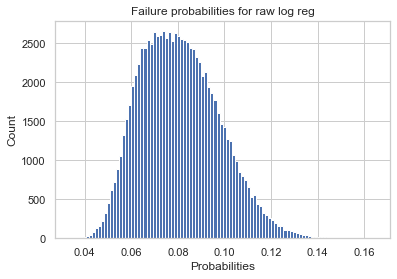

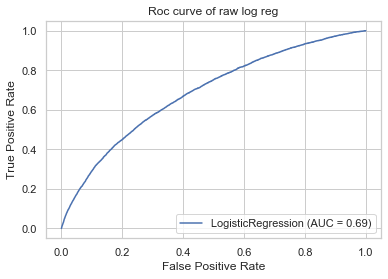

In [22]:
show_results(log_reg, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='raw log reg')

### raw with class weight

In [23]:
# Make the model with the specified regularization parameter
log_reg_weight = LogisticRegression(class_weight='balanced', C=0.0001)

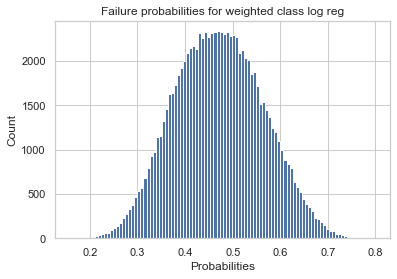

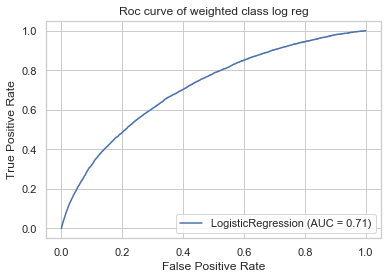

In [24]:
show_results(log_reg_weight, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='weighted class log reg')

## SMOTE

In [25]:
sm = SMOTE(random_state=7)

In [26]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

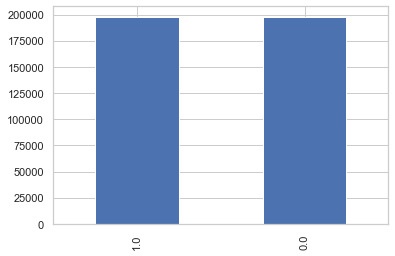

In [27]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

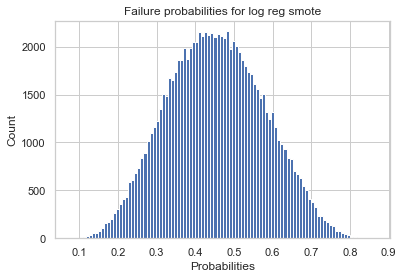

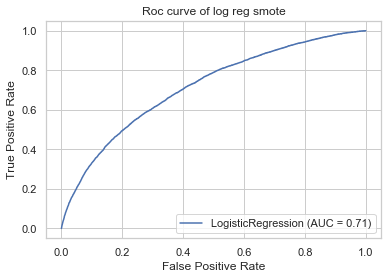

In [28]:
show_results(log_reg, X_train=X_train_new, X_test=X_test, y_train=y_train_new, y_test=y_test, case='log reg smote')

__Logistic Regression with Basic FE and Application df only score around AUC 0.69__

## Random Forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [29]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


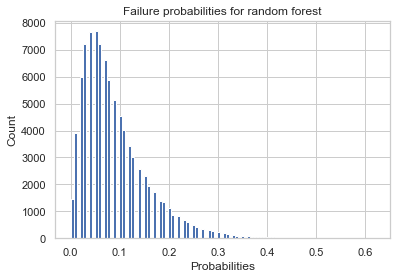

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


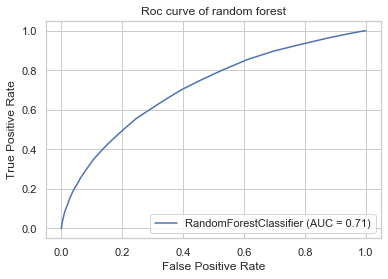

In [30]:
show_results(random_forest, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='random forest')

In [31]:
# Make the random forest classifier
random_forest_weight = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=50,
    verbose=1,
    n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


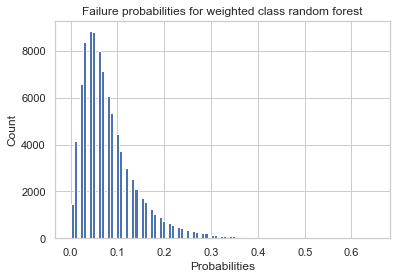

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


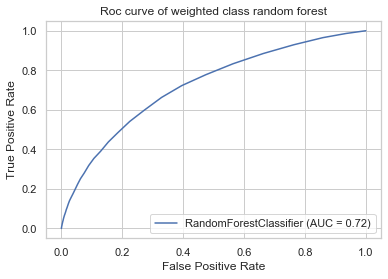

In [32]:
show_results(
    random_forest_weight,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    case='weighted class random forest')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


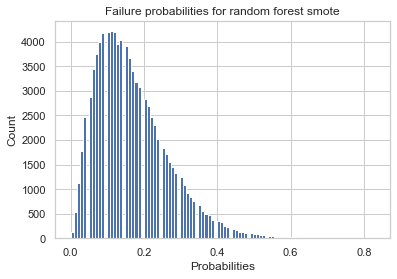

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


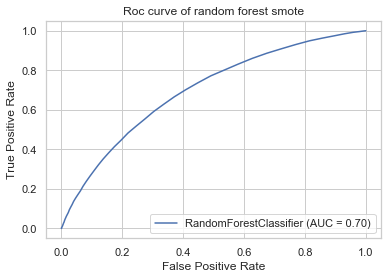

In [33]:
show_results(random_forest,
             X_train=X_train_new,
             X_test=X_test,
             y_train=y_train_new,
             y_test=y_test,
             case='random forest smote')

In [34]:
random_forest.fit(X_train, y_train)
y_pred_1 = random_forest.predict_proba(X_test)[:,1]
fpr1 , tpr1, thr1 = roc_curve(y_test, y_pred_1)
random_forest_weight.fit(X_train, y_train)
y_pred_2 = random_forest_weight.predict_proba(X_test)[:,1]
fpr2 , tpr2, thr2 = roc_curve(y_test, y_pred_2)
random_forest.fit(X_train_new, y_train_new)
y_pred_3 = random_forest.predict_proba(X_test)[:,1]
fpr3 , tpr3, thr3 = roc_curve(y_test, y_pred_3)
log_reg.fit(X_train, y_train)
y_pred_4 = log_reg.predict_proba(X_test)[:,1]
fpr4 , tpr4, thr4 = roc_curve(y_test, y_pred_4)
log_reg_weight.fit(X_train, y_train)
y_pred_5 = log_reg_weight.predict_proba(X_test)[:,1]
fpr5 , tpr5, thr5 = roc_curve(y_test, y_pred_5)
log_reg.fit(X_train_new, y_train_new)
y_pred_6 = log_reg.predict_proba(X_test)[:,1]
fpr6 , tpr6, thr6 = roc_curve(y_test, y_pred_6)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parall

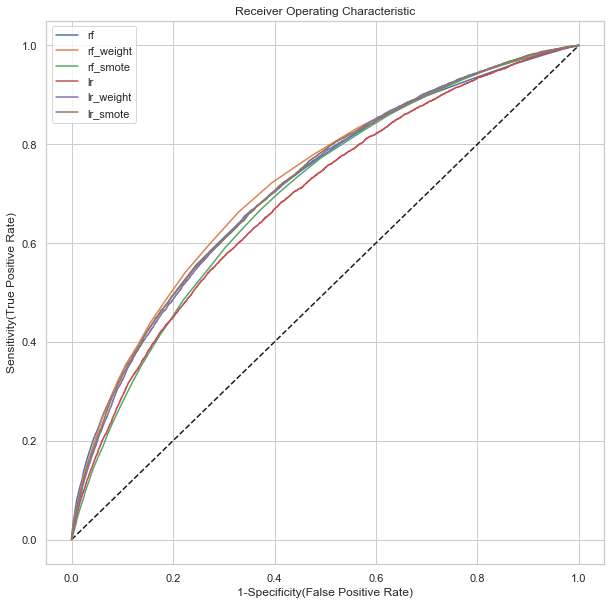

2:12: E231 missing whitespace after ','
2:15: E231 missing whitespace after ','
2:18: E231 missing whitespace after ','


In [35]:
plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label="rf")
plt.plot(fpr2, tpr2, label="rf_weight")
plt.plot(fpr3, tpr3, label="rf_smote")
plt.plot(fpr4, tpr4, label="lr")
plt.plot(fpr5, tpr5, label="lr_weight")
plt.plot(fpr6, tpr6, label="lr_smote")
plt.legend()
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.show()

In [36]:
thr6

array([1.86445514, 0.86445514, 0.84018229, ..., 0.1327365 , 0.13266904,
       0.07725019])

## Features importance

In [37]:
# Train on the training data
random_forest_weight.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=50,
                       verbose=1)

In [38]:
# Extract feature importances
feature_importance_values = random_forest_weight.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [39]:
feature_importances

,feature,importance
0,index,0.022449
1,SK_ID_CURR,0.022543
2,NAME_CONTRACT_TYPE,0.002426
3,CODE_GENDER,0.005525
4,FLAG_OWN_CAR,0.003530
...,...,...
249,WALLSMATERIAL_MODE_Panel,0.001276
250,"WALLSMATERIAL_MODE_Stone, brick",0.001345
251,WALLSMATERIAL_MODE_Wooden,0.000305
252,EMERGENCYSTATE_MODE_No,0.001570


# Scoring

### introduce threshold

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [40]:
# define a function to make threshold adjustable
def threshold_pred(model, X, threshold=0.1):
    pred = model.predict_proba(X)
    y_pred = pred[:, 1] > threshold
    return pred, y_pred.astype(int)

In [41]:
log_reg.fit(X_train, y_train)
pred, y_pred = threshold_pred(log_reg_weight, X_test, threshold=0.5)

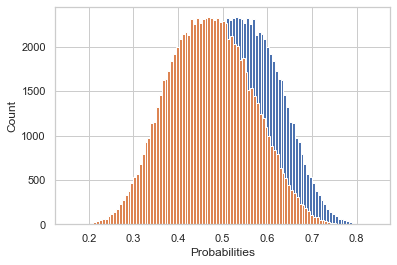

In [42]:
plt.xlabel('Probabilities')
plt.ylabel('Count')
plt.hist(pred[:, 0], bins=100)
plt.hist(pred[:, 1], bins=100)
plt.show()

first, we need to avoid __False Negative__ : approval of any clients with actual defaults is our worts case, predicting target 0 while actual value is 1.
then, we also wish to avoid __False Positive__ : rejecting too many clients who actually would not fail, predicting target 1 while actual value is 0.

In [43]:
# get any case of the confusion matrix
# ravel() is equivalent to flatten for arrays
(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()
(ttn, tfp, tfn, ttp) = confusion_matrix(y_test, y_pred).ravel() / len(y_test)

In [44]:
(tn, fp, fn, tp)

(54837, 29968, 2492, 4956)

In [45]:
(ttn, tfp, tfn, ttp) 

(0.5944196936684986,
 0.3248458044724833,
 0.02701267167463389,
 0.05372183018438425)

In [71]:
pred_nom = log_reg.predict(X_test)
(ntn, nfp, nfn, ntp) = confusion_matrix(y_test, pred_nom).ravel()
(ntn, nfp, nfn, ntp)

(84805, 0, 7448, 0)

In [47]:
# get the precision, recall
precision, recall, f_thresholds = precision_recall_curve(y_test, pred[:, 1])

In [48]:
print(np.count_nonzero(y_test))
print(len(y_test))

7448
92253


In [49]:
# optimal threshold
list_tn = []
list_fp = []
list_fn = []
list_tp = []
list_prec = []
list_rec = []
list_fscore = []
list_gain = []
list_custom = []
threshold_values = []

tp_coef = 0
tn_coef = 1
fn_coef = -7
fp_coef = -1

worst_case = fp_coef * np.count_nonzero(y_test) + tn_coef * (len(y_test) - np.count_nonzero(y_test))
best_case = tn_coef * (len(y_test) - np.count_nonzero(y_test))


for i in np.arange(0, 1, 0.01):
    _, temp_y_pred = threshold_pred(log_reg_weight, X_test, threshold=i)
    tn, fp, fn, tp = confusion_matrix(y_test, temp_y_pred).ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    fscore = 2 * prec * rec / (prec + rec)
    gain = tp * tp_coef + tn * tn_coef + fn * fn_coef + fp * fp_coef
    custom = (gain - worst_case) / (best_case - worst_case)
    threshold_values.append(i)
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    list_prec.append(prec)
    list_rec.append(rec)
    list_fscore.append(fscore)
    list_gain.append(gain)
    list_custom.append(custom)

18:80: E501 line too long (100 > 79 characters)


In [50]:
confusion_matrix_df = pd.DataFrame({'tn': list_tn,
                                    'fp': list_fp,
                                    'fn': list_fn,
                                    'tp': list_tp},
                                   index=threshold_values)

In [51]:
confusion_matrix_df.sample(10)

,tn,fp,fn,tp
0.35,8868,75937,161,7287
0.36,10884,73921,225,7223
0.92,84805,0,7448,0
0.24,212,84593,2,7446
0.65,83132,1673,6719,729
0.25,353,84452,4,7444
0.52,61124,23681,3085,4363
0.11,0,84805,0,7448
0.70,84530,275,7298,150
0.20,12,84793,0,7448


In [52]:
scores_df = pd.DataFrame({'precision': list_prec,
                          'recall': list_rec,
                          'f1score': list_fscore,
                          'gain': list_gain,
                          'custom': list_custom},
                         index=threshold_values)

In [53]:
scores_df.sample(10)

,precision,recall,f1score,gain,custom
0.93,NaN,0.000000,NaN,32669,-6.000000
0.56,0.192765,0.422127,0.264669,28345,-6.580559
0.32,0.083952,0.991004,0.154791,-76740,-20.689715
0.67,0.315627,0.055048,0.093746,33761,-5.853383
0.60,0.236832,0.255371,0.245752,33725,-5.858217
0.28,0.081671,0.997986,0.150987,-82456,-21.457170
0.70,0.352941,0.020140,0.038105,33169,-5.932868
0.87,NaN,0.000000,NaN,32669,-6.000000
0.84,NaN,0.000000,NaN,32669,-6.000000
0.49,0.134922,0.697637,0.226115,2411,-10.062567


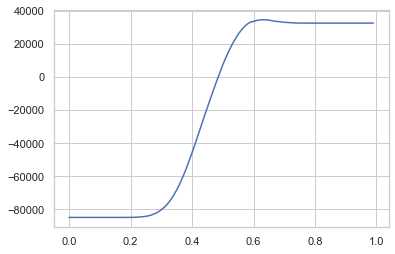

In [54]:
scores_df['gain'].plot()

In [55]:
rates = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn', 'tp', 'tn']]

In [56]:
tot_rate = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']].sum(axis=1)

In [58]:
# precision = precision_recall_df['precision']

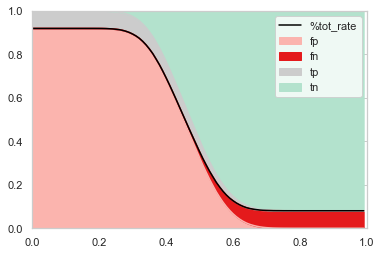

In [59]:
fig, ax = plt.subplots()
pal = ['#fbb4ae', '#e41a1c', '#cccccc', '#b3e2cd']
rates.plot(kind='area', stacked=True, ax=ax, color=pal)
tot_rate.plot(ax=ax, color='black', label='%tot_rate')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

We have to find the right balance (cost) between both case to catch an optimal threshold : fn is n times worst than fp. as it primarily depends on the famous {X, Y} parameters, leading to a damage we have no clue to compute, we don't know real value of n. <br/>
n would surely be different for revolving or high amount credits. <br/>
let's start with 7, just to see the resulting shape of a damage value.

In [60]:
damage_df = pd.DataFrame({'fp damages : unit': confusion_matrix_df['fp'],
                          'fn damages : 7x unit': 7 * confusion_matrix_df['fn']})

In [61]:
damages = (damage_df/damage_df.sum(axis=1).max())

In [62]:
tot_damage = (damage_df.sum(axis=1)/damage_df.sum(axis=1).max())

In [63]:
np.argmin(tot_damage)

57

In [64]:
scores_df.head(3)

,precision,recall,f1score,gain,custom
0.00,0.080735,1.0,0.149407,-84805,-21.772556
0.01,0.080735,1.0,0.149407,-84805,-21.772556
0.02,0.080735,1.0,0.149407,-84805,-21.772556


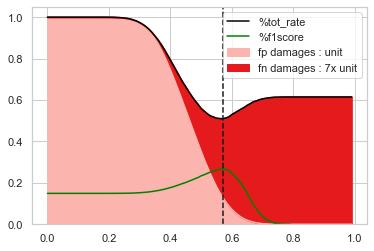

In [65]:
fig, ax = plt.subplots()
damages.plot(kind='area', stacked=True, ax=ax, color=pal)
tot_damage.plot(ax=ax, color="black", label="%tot_rate")
# scores_df['precision'].plot(ax=ax, color='green', label='%precision')
# scores_df['recall'].plot(ax=ax, color='red', label='%recall')
scores_df['f1score'].plot(ax=ax, color='green', label='%f1score')
plt.axvline(x=0.57, color='k', linestyle='--')
# ax.set_xlim(0, 0.8)
# ax.set_ylim(0, 1)
ax.legend()
plt.show()

In [67]:
# print(precision_recall_df['f1score'].idxmax())
# print(precision_recall_df.loc[precision_recall_df['f1score'].idxmax(), 'f1score'])

2:80: E501 line too long (84 > 79 characters)
2:80: E501 line too long (84 > 79 characters)


In [68]:
# refine optimal threshold

list_tn = []
list_fp = []
list_fn = []
list_tp = []
threshold_values =[]

for i in np.arange(0,0.2,0.01) :
    temp_y_pred = threshold_pred(random_forest, X_test, threshold=i)
    tn, fp, fn, tp = confusion_matrix(y_test, temp_y_pred).ravel()
    print(tn, fp, fn, tp)
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    threshold_values.append(i)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


ValueError: Found input variables with inconsistent numbers of samples: [92253, 2]

7:19: E225 missing whitespace around operator
9:21: E231 missing whitespace after ','
9:25: E231 missing whitespace after ','
31: E203 whitespace before ':'


In [ ]:
adj_confusion_matrix_df = pd.DataFrame({'tn' : list_tn,
                                        'fp' : list_fp,
                                        'fn' : list_fn,
                                        'tp' : list_tp},
                                        index=threshold_values) 

In [ ]:
adj_rates = adj_confusion_matrix_df.divide(adj_confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']]
adj_tot_rate = adj_confusion_matrix_df.divide(adj_confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']].sum(axis=1)

In [ ]:
fig, ax = plt.subplots()
adj_rates.plot(kind='area', stacked=True, ax=ax)
adj_tot_rate.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [69]:
adj_damage_df = pd.DataFrame({'fp damages : unit' : adj_confusion_matrix_df['fp'],
                              'fn damages : 7x unit' : 7 * adj_confusion_matrix_df['fn']})

adj_damages = (adj_damage_df/adj_damage_df.sum(axis=1).max())

adj_tot_damage = (adj_damage_df.sum(axis=1)/adj_damage_df.sum(axis=1).max())

NameError: name 'adj_confusion_matrix_df' is not defined

50: E203 whitespace before ':'
1:80: E501 line too long (82 > 79 characters)
53: E203 whitespace before ':'
2:80: E501 line too long (90 > 79 characters)


NameError: name 'adj_damages' is not defined

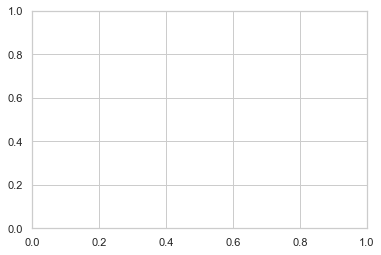

4:14: E231 missing whitespace after ','
5:14: E231 missing whitespace after ','


In [70]:
fig, ax = plt.subplots()
adj_damages.plot(kind='area', stacked=True, ax=ax)
adj_tot_damage.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [ ]:
# optimal threshold
adj_damage_df.sum(axis=1).idxmin()

#### Same with class_weight

In [ ]:
random_forest_weight.predict_proba(X_test)[:, 1]

In [ ]:
# optimal threshold

list_tn = []
list_fp = []
list_fn = []
list_tp = []
threshold_values =[]

for i in np.arange(0,1,0.05) :
    temp_y_pred = threshold_pred(random_forest_weight, X_test, threshold=i)
    tn, fp, fn, tp = confusion_matrix(y_test, temp_y_pred).ravel()
    print(tn, fp, fn, tp)
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    threshold_values.append(i)

In [ ]:
confusion_matrix_df = pd.DataFrame({'tn' : list_tn,
                                    'fp' : list_fp,
                                    'fn' : list_fn,
                                    'tp' : list_tp},
                                   index=threshold_values)

In [ ]:
rates = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']]

In [ ]:
tot_rate = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']].sum(axis=1)

In [ ]:
fig, ax = plt.subplots()
rates.plot(kind='area', stacked=True, ax=ax)
tot_rate.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

We have to find the right balance (cost) between both case to catch an optimal threshold : fn is n times worst than fp. as it primarily depends on the famous {X, Y} parameters, leading to a damage we have no clue to compute, we don't know real value of n. <br/>
n would surely be different for revolving or high amount credits. <br/>
let's start with 7, just to see the resulting shape of a damage value.

In [ ]:
damage_df = pd.DataFrame({'fp damages : unit' : confusion_matrix_df['fp'],
                          'fn damages : 7x unit' : 7 * confusion_matrix_df['fn']})

In [ ]:
damages = (damage_df/damage_df.sum(axis=1).max())

In [ ]:
tot_damage = (damage_df.sum(axis=1)/damage_df.sum(axis=1).max())

In [ ]:
fig, ax = plt.subplots()
damages.plot(kind='area', stacked=True, ax=ax)
tot_damage.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

#### Testing Domain Features

Now we can test the domain features we made by hand.

In [ ]:
# same with so called "domain" features
if 'TARGET' in app_train:
    X_domain = app_train_domain.drop(columns = ['TARGET'])
else:
    X_domain = app_train_domain.copy()
y_domain = app_train_domain['TARGET']
    
# Feature names
domain_features_names = list(X_domain.columns)


# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit-transform training dataset
X_domain = imputer.fit_transform(X_domain)

# Repeat with the scaler
X_domain = scaler.fit_transform(X_domain)

# Split data into train and test set (stratify by target)
X_dom_train, X_dom_test, y_dom_train, y_dom_test = train_test_split(X_domain, y_domain, stratify=y_domain, test_size=0.3, random_state=42)


print('Training data shape: ', X_dom_train.shape)
print('Testing data shape: ', X_dom_test.shape)

print('Labels train data shape: ', y_dom_train.shape)
print('Labels test data shape: ', y_dom_test.shape)

In [ ]:
# Make the random forest classifier
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_domain.fit(X_dom_train, y_dom_train)

# Extract feature importances
feature_importance_domain_values = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_domain_values})

# Make predictions on the test data
ran_for_dom_pred = random_forest_domain.predict_proba(X_dom_test)[:, 1]

__Random Forest with Basic FE and Application df only score around AUC 0.71__

#### Testing transparency 

Now we can test the removal of ext_ features as well as SK ID

In [ ]:
# same with so called "domain" features
app_transp = app_train_domain.drop(columns = ['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])


if 'TARGET' in app_train:
    X_transp = app_transp.drop(columns = ['TARGET'])
else:
    X_transp = app_transp.copy()
y_transp = app_transp['TARGET']
    
# Feature names
transp_features_names = list(X_transp.columns)


# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit-transform training dataset
X_transp = imputer.fit_transform(X_transp)

# Repeat with the scaler
X_transp = scaler.fit_transform(X_transp)

# Split data into train and test set (stratify by target)
X_transp_train, X_transp_test, y_transp_train, y_transp_test = train_test_split(X_transp, y_transp, stratify=y_transp, test_size=0.3, random_state=42)


print('Training data shape: ', X_transp_train.shape)
print('Testing data shape: ', X_transp_test.shape)

print('Labels train data shape: ', y_transp_train.shape)
print('Labels test data shape: ', y_transp_test.shape)

In [ ]:
# Make the random forest classifier
random_forest_transp = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_transp.fit(X_transp_train, y_transp_train)

# Extract feature importances
feature_importance_transp_values = random_forest_transp.feature_importances_
feature_importances_transp = pd.DataFrame({'feature': transp_features_names, 'importance': feature_importance_transp_values})

# Make predictions on the test data
ran_for_transp_pred = random_forest_transp.predict_proba(X_transp_test)[:, 1]

In [ ]:
auc_scor = roc_auc_score(y_transp_test, ran_for_transp_pred)
print("AUC score: ", auc_scor)

print("Confusion matrix: ")
print(confusion_matrix(y_transp_test, ran_for_dom_pred.round(), normalize=None))

print("Accuracy score: ", accuracy_score(y_transp_test, ran_for_dom_pred.round()))
print("Recall score: ", recall_score(y_transp_test, ran_for_dom_pred.round()))
print("F1-score: ", f1_score(y_transp_test, ran_for_dom_pred.round()))

__Random Forest for transparency ! with Basic FE and Application df only score around AUC 0.65__

## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 12))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['importance_normalized'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions. 

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

In [ ]:
feature_importances_transp_sorted = plot_feature_importances(feature_importances_transp)

# Just for Fun: Light Gradient Boosting Machine

Now (if you want, this part is entirely optional) we can step off the deep end and use a real machine learning model: the [gradient boosting machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) using the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html)! The Gradient Boosting Machine is currently the leading model for learning on structured datasets (especially on Kaggle) and we will probably need some form of this model to do well in the competition. Don't worry, even if this code looks intimidating, it's just a series of small steps that build up to a complete model. I added this code just to show what may be in store for this project, and because it gets us a slightly better score on the leaderboard. In future notebooks we will see how to work with more advanced models (which mostly means adapting existing code to make it work better), feature engineering, and feature selection. See you in the next notebook!  

In [ ]:
import lightgbm as lgb


def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

## Remedy imbalanced data with upsampling using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('baseline_lgb.csv', index = False)

This submission should score about 0.735 on the leaderboard. We will certainly best that in future work! 

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

Again, we see tha some of our features made it into the most important. Going forward, we will need to think about whatother domain knowledge features may be useful for this problem (or we should consult someone who knows more about the financial industry! 

In [ ]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

This model scores about 0.754 when submitted to the public leaderboard indicating that the domain features do improve the performance! [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is going to be a critical part of this competition (as it is for all machine learning problems)!